Aim:
======
The aim of this session is to familiarize yourselves with nonlinear dimensionality reduction techniques using medical data. For the purposes of this session, we are going to use a subset of the data from the [M&M Challenge](https://www.ub.edu/mnms/).

More precisely, in this notebook we will apply the following dimensionality reductions techniques:
  1. Kernel PCA
  2. Local linear embedding
  3. Isomap
  4. t-sne (for visualization purposes only)

First, we will split our data in training and testing. Subsequently, we will  perfrom basic exploratory analysis and dimensionality reduction. Moreover, we will perform some basic classification to see the impact of the different dimensionality reduction methods in the classifier's performance. Lastly, we will apply t-sne for visualization purposes.

Dataset information
===============
The Multi-Centre, Multi-Vendor & Multi-Disease Cardiac Image Segmentation Challenge (M&Ms) was organized as part of the MICCAI 2020 conference, the most important conference in artificial intelligence for medical imaging for benchmarking cardiac segmentation algorithms.


The M&M dataset contains cardiac magnetic resonance (CMR) from people with hypertrophic, dilated cardiomyopathies as well as healthy subjects. All subjects were scanned in clinical centres in three different countries (Spain, Germany and Canada) using four different magnetic resonance scanner vendors (Siemens, General Electric, Philips and Canon) making the segmentation and classification tasks particularly challenged compared to data originating from a single center.

The CMR images were used to extract high-throughput features, known as radiomics to characterize the shape, first-order intensities and textures of the main stuctures of interest: left ventricle (LV), right ventricle (RV) and myocardium (MYO). To this end, the [pyradiomics](https://pyradiomics.readthedocs.io/en/latest/) library was used.

For this session, we are going to use a reduced set of features and participants. More precisely, we are going to focus in individuals with hypertrophic cardiomyopathy (HCM) and healthy people (NOR). Regarding the features, here we will only consider features from  the end-diastole from the LV and myocardium, ignoring the RV.

For more information regarding the M&M and for downloading the original CMR data, please visit https://www.ub.edu/mnms/

Author: Polyxeni Gkontra, Machine Learning for Precision Medicine, MBDS, 2024


Load the data & split to training-testing set
=================

Import libraries

In [1]:
import numpy as np
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Upload the file with the data to colab

In [ ]:
#from google.colab import files
# Load the file - a window will prompt to choose from your local system
#uploaded = files.upload()

Import the file as a dataframe and patients and keep patients from the two conditions of interest (HCM, NOR)

In [2]:
# Load the data into a dataframe
data_all = pd.read_csv('Dataset/dataset_MandM.csv')
# Keep only patients with the following dieases
# dis_keep = data_all['Diagnosis'].unique()
dis_keep = ['HCM', 'NOR']
data_all = data_all[(data_all['Diagnosis'].isin(dis_keep))]

From the original dataframe, create two separate dataframes: one that contains the features and one that contains the diagnosis

In [3]:
# Drop the column with patient id
data_all.drop(columns = ['Patient_id'], inplace = True)
# Create a dataframe with only the features
X_all = data_all.drop(columns = ['Diagnosis'])
# Create another dataframe with the diagnosis
Y_all = pd.DataFrame([], columns=['Diagnosis'])
Y_all['Diagnosis'] = data_all['Diagnosis']
# Print the diseases
print(Y_all['Diagnosis'].unique())

['HCM' 'NOR']


Split the data into training and testing set. Here, we will follow a simple approach of using 80% of data for training and 20% for testing. Useful: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, shuffle=True, random_state=42)

Check the size of the splitted data

In [5]:
print("The shape of the X train data is: ", X_train.shape)
print("The shape of the Y train data is: ", Y_train.shape)
print("The shape of the X test data is: ", X_test.shape)
print("The shape of the Y test data is: ", Y_test.shape)

The shape of the X train data is:  (111, 210)
The shape of the Y train data is:  (111, 1)
The shape of the X test data is:  (28, 210)
The shape of the Y test data is:  (28, 1)


Basic exploratory analysis
=============================
Apply the methods and strategies taught in previous classes to explore the basic properties of the dataset. Useful: [countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html), [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html), [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) from from the [seaborn library](https://seaborn.pydata.org/index.html), and [concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html), [corr](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) from [pandas](https://pandas.pydata.org/docs/index.html)

In [6]:
# Print the names of the features (columns of X dataframe)
print(X_train.columns)
# Print summary statistics regarding the features (X dataframe)
print(X_train.info(verbose=True))
#print(X_train.describe())

Index(['Volume_LV_ED', 'SurfaceArea_LV_ED', 'SurfaceAreatoVolumeRatio_LV_ED',
       'Sphericity_LV_ED', 'Max3Ddiameter_LV_ED', 'Max2DdiameterSlice_LV_ED',
       'Max2DdiameterColumn_LV_ED', 'Max2DdiameterRow_LV_ED',
       'MajorAxis_LV_ED', 'MinorAxis_LV_ED',
       ...
       'DependenceNonUniformityNormalized_gldm_MYO_ED',
       'GrayLevelVariance_gldm_MYO_ED', 'DependenceVariance_gldm_MYO_ED',
       'DependenceEntropy_gldm_MYO_ED', 'LowGrayLevelEmphasis_gldm_MYO_ED',
       'HighGrayLevelEmphasis_gldm_MYO_ED',
       'SmallDependenceLowGrayLevelEmphasis_gldm_MYO_ED',
       'SmallDependenceHighGrayLevelEmphasis_gldm_MYO_ED',
       'LargeDependenceLowGrayLevelEmphasis_gldm_MYO_ED',
       'LargeDependenceHighGrayLevelEmphasis_gldm_MYO_ED'],
      dtype='object', length=210)
<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, 16 to 170
Data columns (total 210 columns):
 #    Column                                            Dtype  
---   ------                             

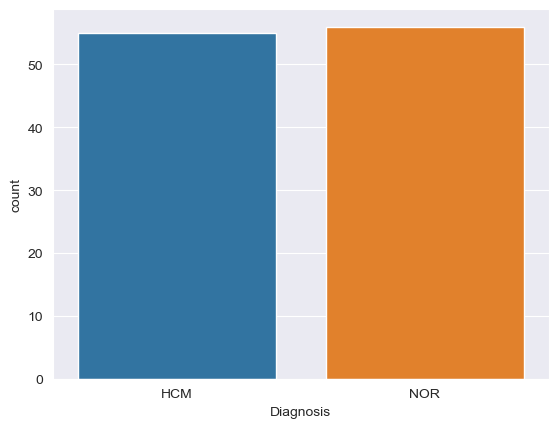

In [7]:
# Create a countplot with the number of patients per category
ax = sns.countplot(data = Y_train, x = 'Diagnosis', hue = 'Diagnosis');

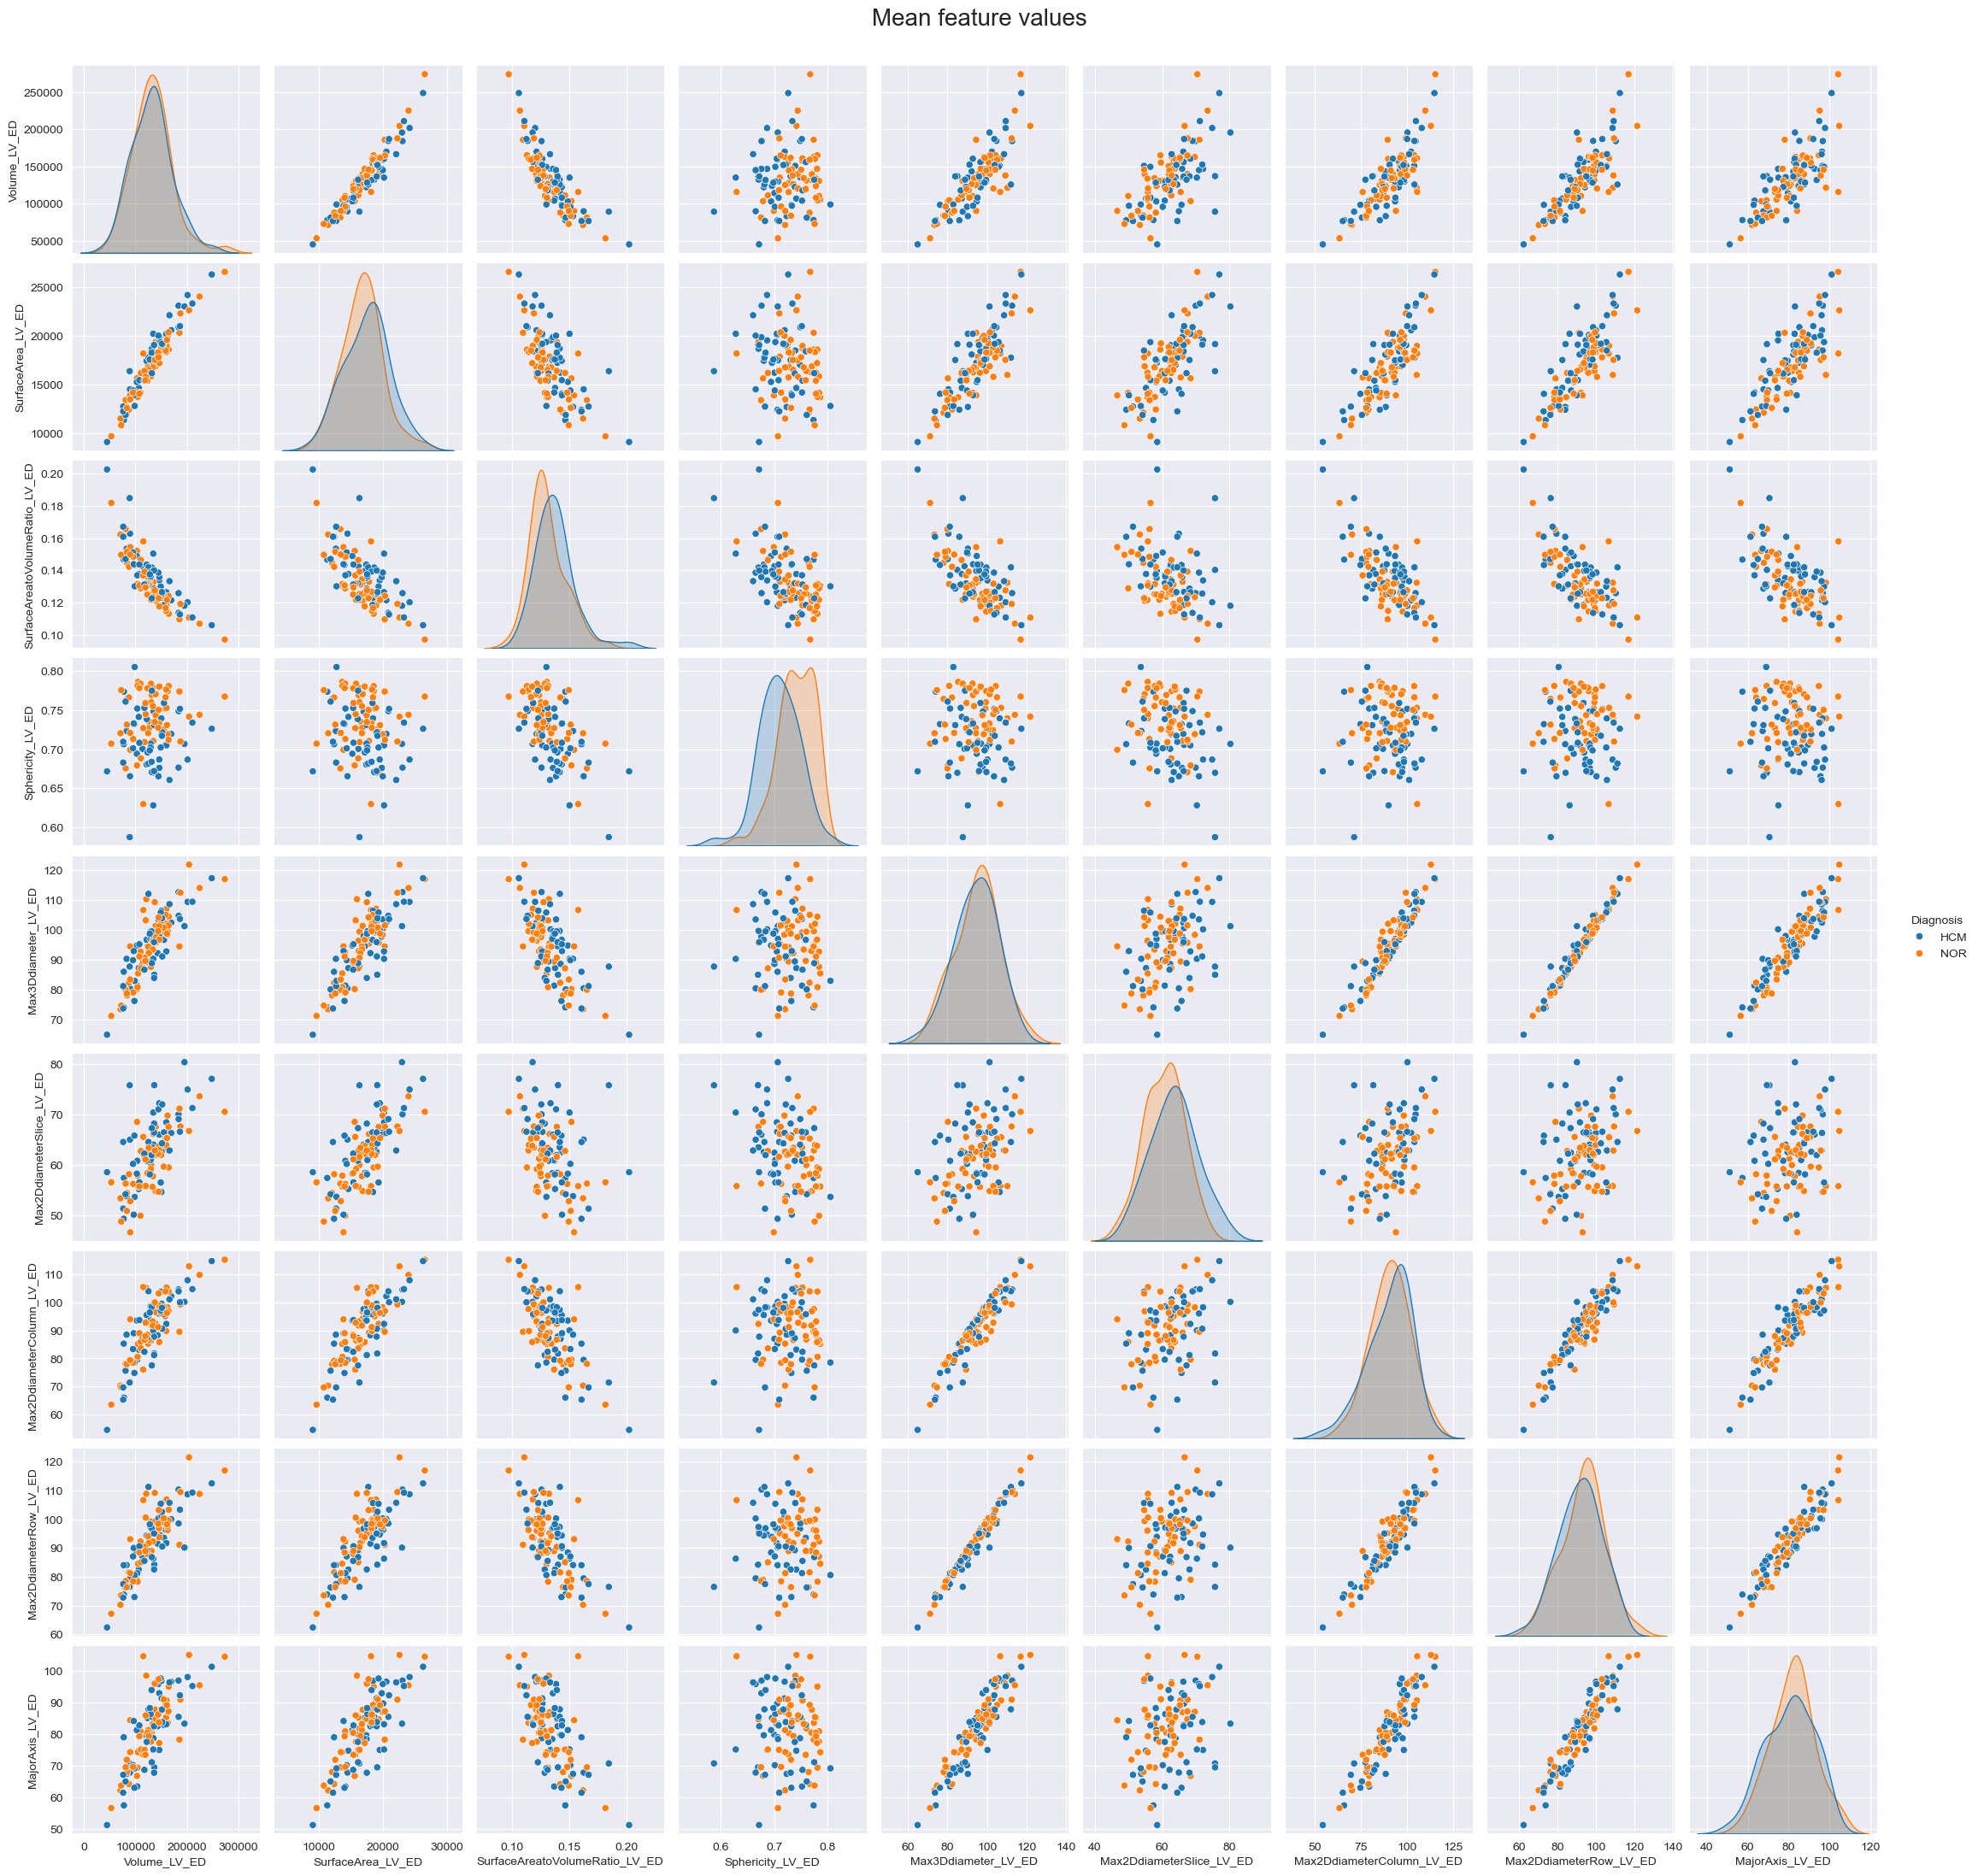

In [8]:
# Concatenate Y_train and X_train to create a common dataframe with input and output to use with pairplot
data_all_train = pd.concat([Y_train, X_train], axis=1)
# Create a pairplot with the first 10 features including 'Diagnosis' in them
ax = sns.pairplot(data_all_train.iloc[:,:10], hue = 'Diagnosis')
ax.fig.suptitle('Mean feature values', fontsize = 20)
ax.fig.subplots_adjust(top = 0.95);

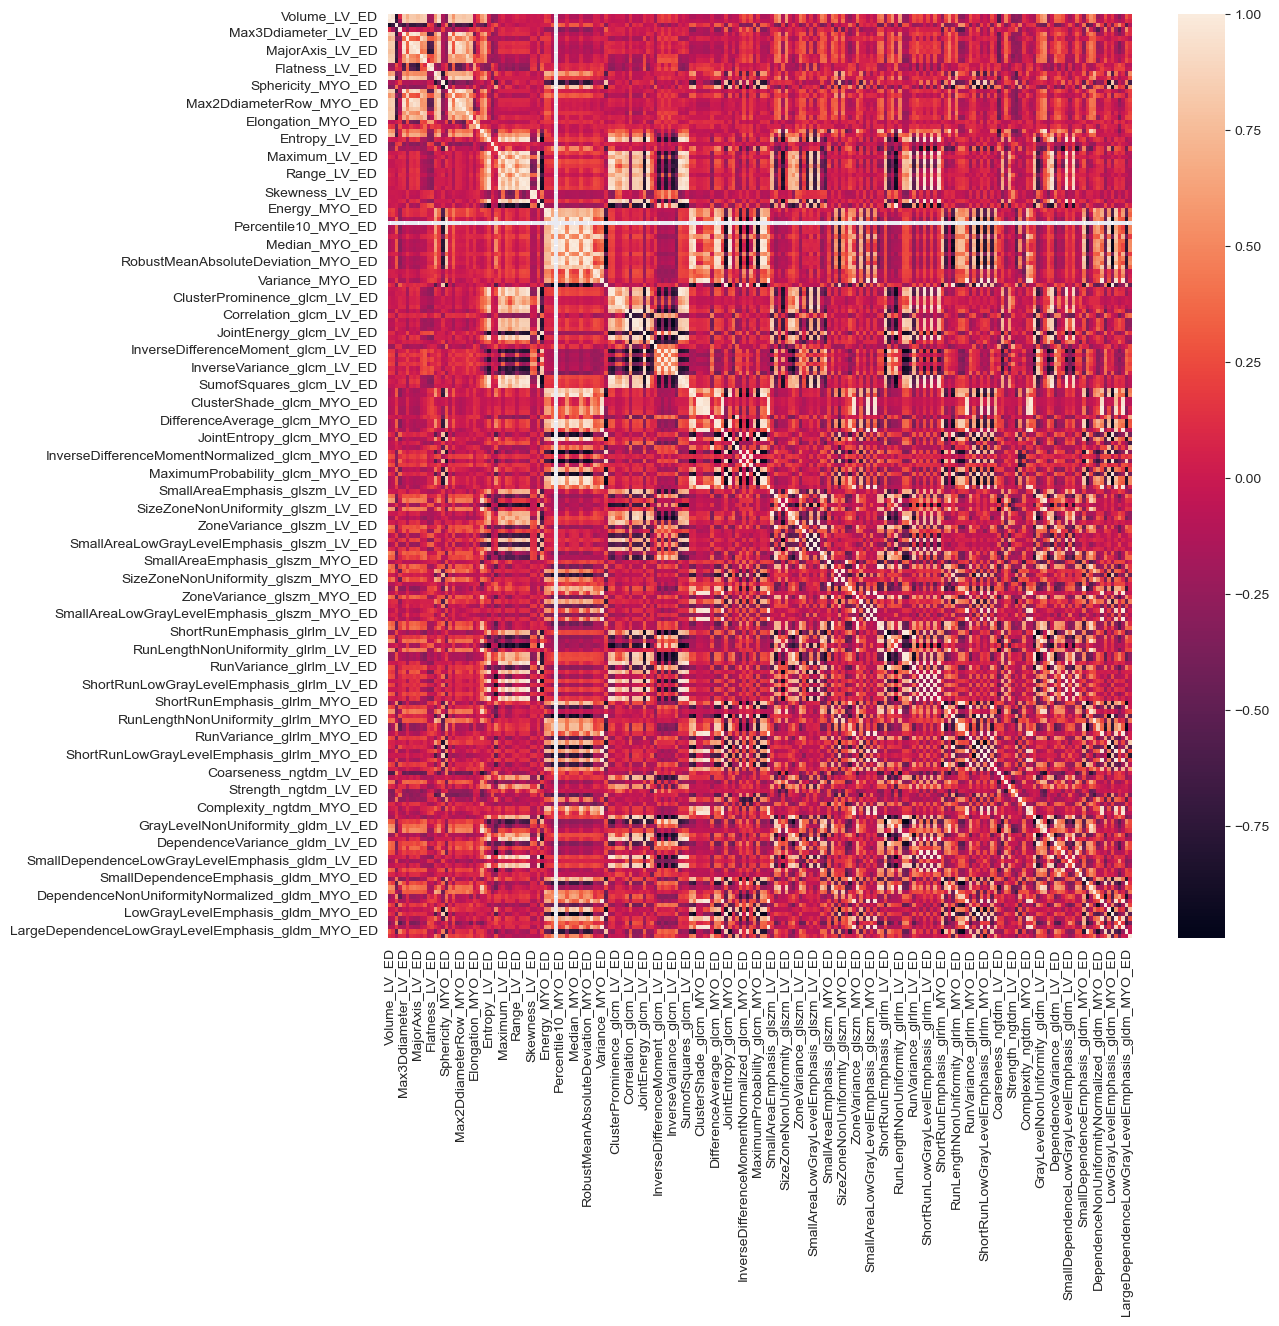

In [9]:
# Create a heatmap with the correlations between all features
plt.figure(figsize=(12, 12))
sns.heatmap(X_train.corr());

Kernel PCA
============================
Kernel PCA is an extension of PCA for non-linear problems where data is not linear separable.
Remember that kernel PCA is based on the kernel trick, ie the data are represented through a set of pairwise similarity distances using the original point coordinates instead of calculating the coordinates at the high dimensional space that kernal PCA transform the data in order to separate them.

Import the necessary libraries

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA

What do you think would be the first step?

In [11]:
# Standardise the data
scaler = StandardScaler()
# Fit to the training data
scaler = scaler.fit(X_train)
# Tranform training data
X_scaled = scaler.transform(X_train)
# Tranform testing data
X_test_scaled = scaler.transform(X_test)
# Number of components to use
n_comp = 15;

Apply kernel PCA using a linear kernel and compute the explained variance. To what is this equivalent? Useful functions:  [KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)

In [12]:
kpca_linear = KernelPCA(kernel="linear",
                n_components=n_comp)
X_kpca_linear = kpca_linear.fit_transform(X_scaled)

Look at the explained variance. KernelPCA does not offer the attributes regarding the explained variances as PCA class, so we are going to calculate it from the data. We will convert this in function as we will use it several times.

In [13]:
def explained_variance_kpca(data_plot, tit):
  # Explained variance
  explained_variance = np.var(data_plot, axis=0)
  # Explained variance ratio
  explained_variance_ratio = explained_variance / np.sum(explained_variance)
  # Explained cumulative variance
  cum_var= np.cumsum(explained_variance_ratio)
  print('Explained cumulative variance ratio:', cum_var)
  # Create plot with cumulative variance versus components
  plt.plot(list(range(1,data_plot.shape[1]+1)),100*cum_var, marker='o', linestyle='-', color='black')
  plt.xlabel('Number of components');
  plt.ylabel('Cumulative variance (%) ');
  plt.axhline(95, color='red', linestyle='--');
  # Force integer xtick labels
  plt.xticks(range(1, data_plot.shape[1]+1));
  plt.title('Kernel PCA with ' + tit + ' kernel');
  return cum_var;

Explained cumulative variance ratio: [0.29803951 0.49596001 0.6447918  0.72987047 0.79484112 0.84890477
 0.88162684 0.90913335 0.93011893 0.94552107 0.96046414 0.97310217
 0.98326479 0.99241253 1.        ]


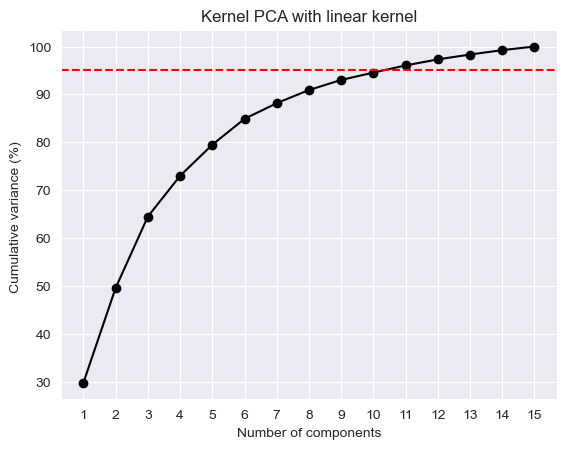

In [14]:
# Calculate explained_variance_kpca to caluclate the variance and plot it
cum_var = explained_variance_kpca(X_kpca_linear, 'linear')

Actually run PCA to verify it and create a plot as above

Explained cumulative variance ratio: [0.29803951 0.49596001 0.6447918  0.72987047 0.79484112 0.84890477
 0.88162684 0.90913335 0.93011893 0.94552107 0.96046414 0.97310217
 0.98326479 0.99241253 1.        ]


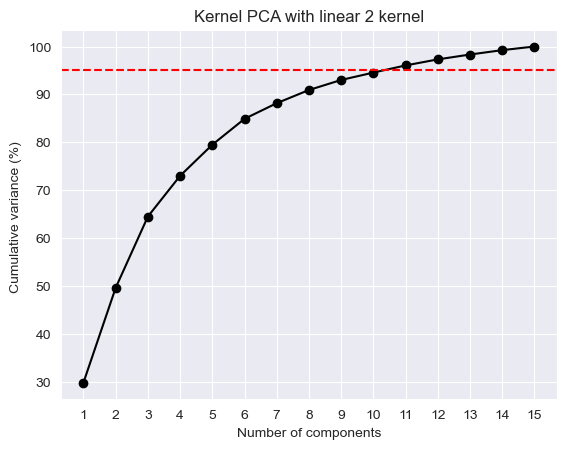

In [15]:
# Define transform
pca = PCA(n_components = 15)
# Fit and transform the data
X_pca = pca.fit_transform(X_scaled)
# Calculate explained_variance_kpca to caluclate the variance and plot it
cum_var = explained_variance_kpca(X_pca, 'linear 2')

You are correct, using a linear kernal is equivalent to running linear PCA. Now try out the following kernels, compute the explained variance and create a comparitive plot:
- ‘poly’
- ‘rbf’
- ‘sigmoid’
- ‘cosine’

Explained cumulative variance ratio: [0.91778459 0.95238127 0.96438049 0.97325658 0.97752957 0.98129322
 0.98475349 0.98774788 0.99032051 0.99240955 0.99424786 0.99605608
 0.99765031 0.99890301 1.        ]


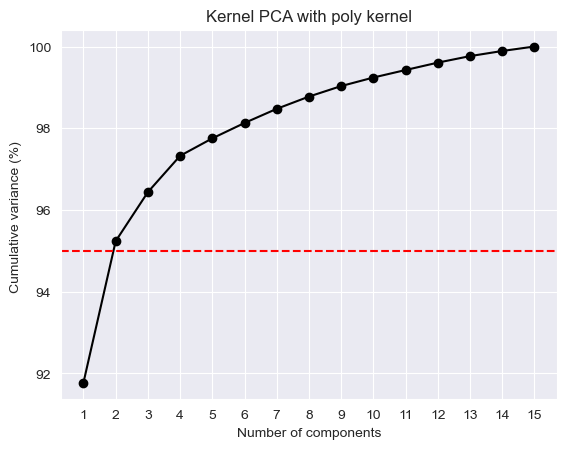

In [16]:
# Define transformation for kernel PCA with polynomial kernel
kpca_poly = KernelPCA(kernel="poly", degree=5,
                n_components = n_comp)
X_kpca_poly = kpca_poly.fit_transform(X_scaled)
cum_var = explained_variance_kpca(X_kpca_poly, 'poly')

Explained cumulative variance ratio: [0.20152081 0.36284908 0.47557508 0.56348487 0.63672236 0.70001664
 0.74609607 0.78818031 0.82772061 0.86062634 0.89294825 0.92194059
 0.95018771 0.97566047 1.        ]


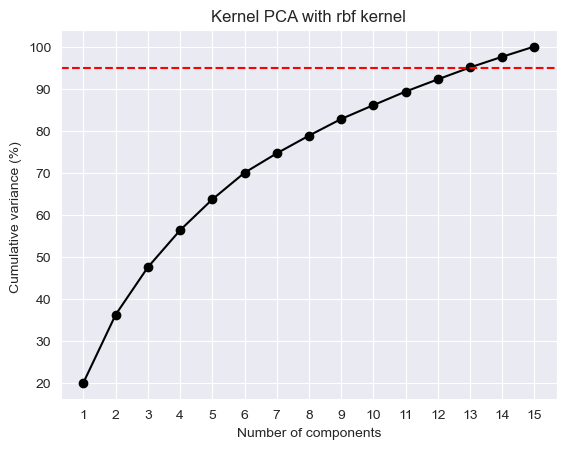

In [17]:
# Define transformation for kernal PCA with radial basis functions
kpca_rbf = KernelPCA(kernel="rbf", n_components = n_comp)
X_kpca_rbf = kpca_rbf.fit_transform(X_scaled)
cum_var = explained_variance_kpca(X_kpca_rbf, 'rbf')

Explained cumulative variance ratio: [0.20152081 0.36284908 0.47557508 0.56348487 0.63672236 0.70001664
 0.74609607 0.78818031 0.82772061 0.86062634 0.89294825 0.92194059
 0.95018771 0.97566047 1.        ]


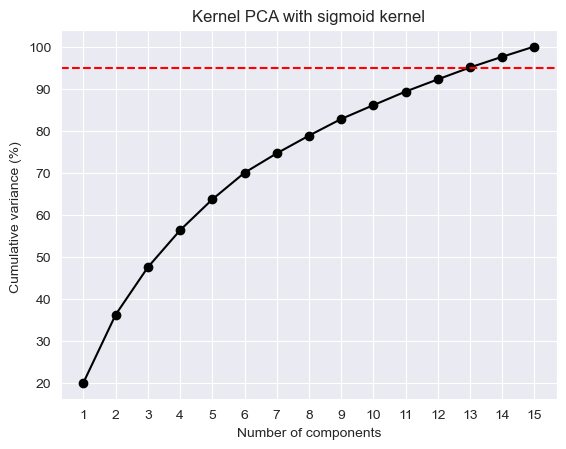

In [18]:
# Define transformation for kernal PCA with sigmoid kernel function
kpca_sig = KernelPCA(kernel="sigmoid", n_components = n_comp)
X_kpca_sig = kpca_sig.fit_transform(X_scaled)
cum_var = explained_variance_kpca(X_kpca_rbf, 'sigmoid')

Explained cumulative variance ratio: [0.27230129 0.47915827 0.62352922 0.70868674 0.77751224 0.82724919
 0.86626206 0.89542437 0.91860505 0.93723458 0.95385557 0.96760223
 0.98006385 0.99089942 1.        ]


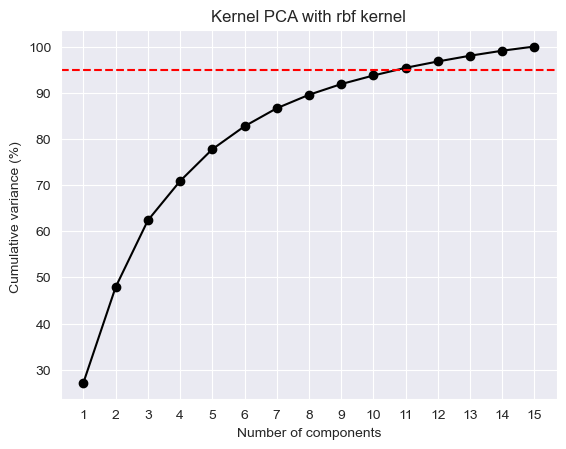

In [19]:
# Define transformation for kernal PCA with cosine kernel function
kpca_cos = KernelPCA(kernel="cosine", n_components = n_comp)
X_kpca_cos = kpca_cos.fit_transform(X_scaled)
cum_var = explained_variance_kpca(X_kpca_cos, 'rbf')

Repeat the above with just 2 components. Apply the learned transformations to testing data using transform

In [20]:
# Linear kernel PCA applied to test data
X_test_kpca_linear = kpca_linear.transform(X_test_scaled)
# Kernel PCA with polynomial kernel applied to test data
X_test_kpca_poly = kpca_poly.transform(X_test_scaled)
# Kernel PCA with rbf kernel applied to test data
X_test_kpca_rbf = kpca_rbf.transform(X_test_scaled)
# Kernel PCA with sigmoid kernel function applied to test data
X_test_kpca_sig = kpca_sig.transform(X_test_scaled)
# Kernel PCA with cosine kernel applied to test data
X_test_kpca_cos = kpca_cos.transform(X_test_scaled)

Create a plot with the transformed data using the different kernels

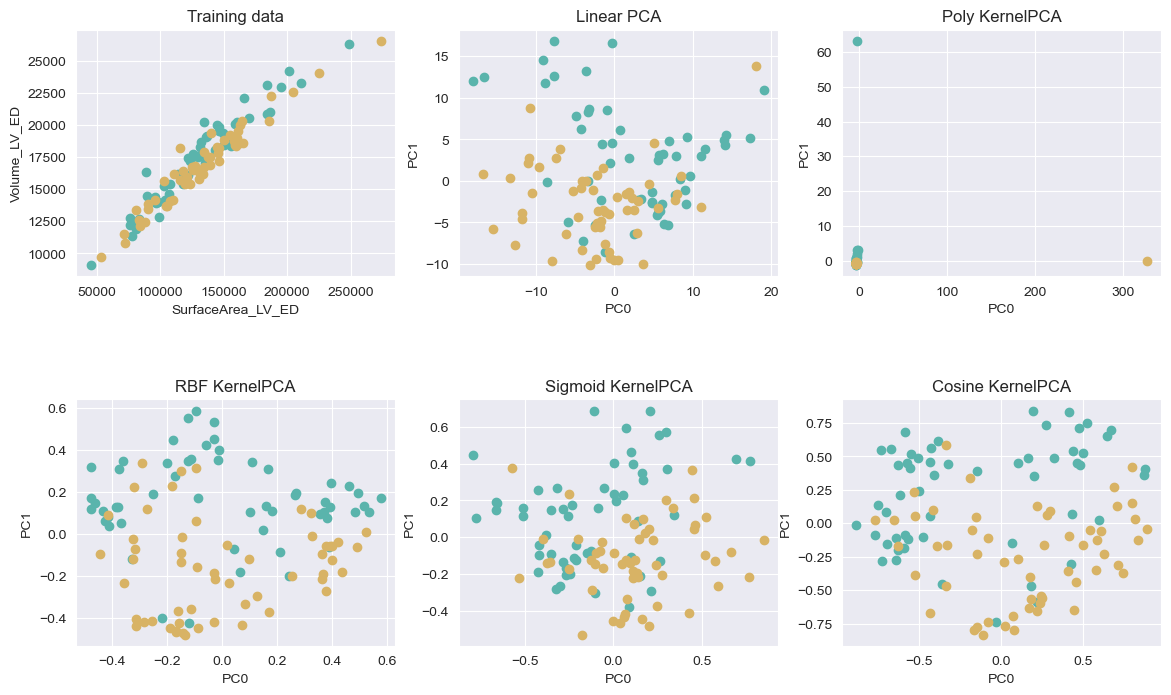

In [21]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5)

colors = ['#5ab4ac', '#d8b365','#a6611a']

for target, color in zip(dis_keep, colors):
    indicesToKeep = Y_train['Diagnosis'] == target
    # Scatter plot for original data
    ax1.scatter(X_train.loc[indicesToKeep, X_train.columns[0]], X_train.loc[indicesToKeep, X_train.columns[1]], c=color)
    ax1.set_ylabel(X_train.columns[0])
    ax1.set_xlabel(X_train.columns[1])
    ax1.set_title("Training data")

    ax2.scatter(X_kpca_linear[indicesToKeep, 0], X_kpca_linear[indicesToKeep, 1], c=color)
    ax2.set_ylabel("PC1")
    ax2.set_xlabel("PC0")
    ax2.set_title("Linear PCA")

    ax3.scatter(X_kpca_poly[indicesToKeep, 0], X_kpca_poly[indicesToKeep, 1], c=color)
    ax3.set_ylabel("PC1")
    ax3.set_xlabel("PC0")
    ax3.set_title("Poly KernelPCA")

    ax4.scatter(X_kpca_rbf[indicesToKeep, 0], X_kpca_rbf[indicesToKeep, 1], c=color)
    ax4.set_ylabel("PC1")
    ax4.set_xlabel("PC0")
    ax4.set_title("RBF KernelPCA")

    ax5.scatter(X_kpca_sig[indicesToKeep, 0], X_kpca_sig[indicesToKeep, 1], c=color)
    ax5.set_ylabel("PC1")
    ax5.set_xlabel("PC0")
    ax5.set_title("Sigmoid KernelPCA")

    ax6.scatter(X_kpca_cos[indicesToKeep, 0], X_kpca_cos[indicesToKeep, 1], c=color)
    ax6.set_ylabel("PC1")
    ax6.set_xlabel("PC0")
    ax6.set_title("Cosine KernelPCA")


Isometric mapping (ISOMAP)
=======

Now we are going to try ISOMAP for our data. ISOMAP tries to find  a lower-dimensional embedding which maintains geodesic distances between all points. To do it constructs a weighted graph. Useful: [isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)

Code in this and following section is based on https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0

In [22]:
from sklearn.manifold import Isomap
import plotly.express as px # for data visualization

Apply Isomap

In [23]:
# Define the tranform
embed_iso = Isomap(
    n_neighbors=5, # default=5, algorithm finds local structures based on the nearest neighbors
    n_components=10, # number of dimensions
    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’
    tol=0, # default=0, Convergence tolerance passed to arpack or lobpcg. not used if eigen_solver == ‘dense’.
    max_iter=None, # default=None, Maximum number of iterations for the arpack solver. not used if eigen_solver == ‘dense’.
    path_method='auto', # {‘auto’, ‘FW’, ‘D’}, default=’auto’, Method to use in finding shortest path.
    neighbors_algorithm='auto', # neighbors_algorithm{‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’
    n_jobs=-1, # n_jobsint or None, default=None, The number of parallel jobs to run. -1 means using all processors
    metric='minkowski', # string, or callable, default=”minkowski”
    p=2, # default=2, Parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2
    metric_params=None # default=None, Additional keyword arguments for the metric function.
)

# Fit and transform the data
embed_iso = embed_iso.fit(X_scaled)
X_iso_train = embed_iso.transform(X_scaled)
X_iso_test = embed_iso.transform(X_test_scaled)

# Print shape of the new dataset
print('The new shape of X: ', X_iso_train.shape)

The new shape of X:  (111, 10)


C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Create an interactive 3D plot for better visualization of the results. We will define this as a function to call it later again. Useful: [scatter_3d](https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d.html) from plotply.express

In [24]:
# Create a 3D scatter plot
def scatter_plot_DR_3D(X_iso_train, Y_train, target = 'Diagnosis'):
    fig = px.scatter_3d(None,
                          x=X_iso_train[:,0], y=X_iso_train[:,1], z=X_iso_train[:,2], color = Y_train[target],
                          height=900, width=900
                        )

    # Update chart looks
    fig.update_layout(#title_text="Scatter 3D Plot",
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1),
                                            center=dict(x=0, y=0, z=-0.2),
                                            eye=dict(x=-1.5, y=1.5, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                            ),
                                  yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                  zaxis=dict(backgroundcolor='lightgrey',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                            )))

    # Update marker size
    fig.update_traces(marker=dict(size=2))

    fig.show()

In [25]:
# Call the scatter_plot_DR_3D
scatter_plot_DR_3D(X_iso_train, Y_train, target = 'Diagnosis')

Linear Local Embedding
==========================


It this part we will apply locally linear embedding (LLE) to our data. LLE tries to find a low-dimensional representation of the data that preserves the distances between neighboring points. It can be conceptualized as a set of localized PCAs, which are then compared globally to identify the optimal non-linear embedding of the data. It involes three main steps: Nearest Neighbors Search, Weight Matrix Construction, Cost function minimization

Import the necessary libraries

In [26]:
from sklearn.manifold import LocallyLinearEmbedding

Apply LLE on training data. Useful: [LocallyLinearEmbedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html) from scikit learn



In [27]:
 # Specify the LLE transform using the default parameters apart from components
embed_lle = LocallyLinearEmbedding(n_neighbors=10, # default=5, number of neighbors to consider for each point.
                    n_components=10, # default=2, number of dimensions of the new space
                    reg=0.001, # default=1e-3, regularization constant, multiplies the trace of the local covariance matrix of the distances.
                    eigen_solver='auto', # {‘auto’, ‘arpack’, ‘dense’}, default=’auto’, auto : algorithm will attempt to choose the best method for input data
                    tol=1e-06, # default=1e-6, Tolerance for ‘arpack’ method. Not used if eigen_solver==’dense’.
                    max_iter=100, # default=100, maximum number of iterations for the arpack solver. Not used if eigen_solver==’dense’.
                    method= 'standard', # {‘standard’, ‘hessian’, ‘modified’, ‘ltsa’}, default=’standard’
                    #hessian_tol=0.0001, # default=1e-4, Tolerance for Hessian eigenmapping method. Only used if method == 'hessian'
                    modified_tol=1e-12, # default=1e-12, Tolerance for modified LLE method. Only used if method == 'modified'
                    neighbors_algorithm='auto', # {‘auto’, ‘brute’, ‘kd_tree’, ‘ball_tree’}, default=’auto’, algorithm to use for nearest neighbors search, passed to neighbors.NearestNeighbors instance
                    random_state=42, # default=None, Determines the random number generator when eigen_solver == ‘arpack’. Pass an int for reproducible results across multiple function calls.
                    n_jobs=-1 # default=None, The number of parallel jobs to run. -1 means using all processors.
                   )
# Fit and transofrm the data
embed_lle = embed_lle.fit(X_scaled)
X_lle_train = embed_lle.transform(X_scaled)
X_lle_test = embed_lle.transform(X_test_scaled)
# Create an interactive plot
scatter_plot_DR_3D(X_lle_train, Y_train, target = 'Diagnosis')

Why do Isomap and LLE have so low performance? Do you think we can improve the results?



t-sne
======

Use to t-sne to visualize of the data

In [36]:
#import TSNE
from sklearn.manifold import TSNE,trustworthiness

In [130]:
# Based on https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb

# This uses perplexity=t and random initialisation
# The result will depend on the random seed (here, 42)

#tsne_default = fast_tsne(X_scaled, perplexity=30, seed=42)
tsne = TSNE(n_components=2,perplexity=30, random_state=42)
tsne_default = tsne.fit_transform(X_scaled)
#Trustworthiness of the low-dimensional space compared to the high dimensional space [0,1]
Trst=trustworthiness(X_scaled, tsne_default)
Trst

0.9549724481763316

Create a plot

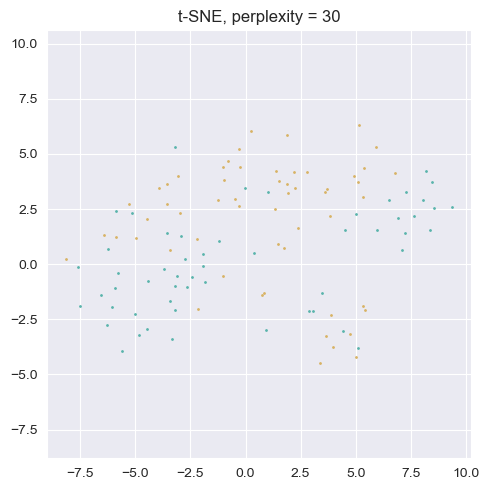

In [131]:
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal', adjustable='datalim')
colors = ['#5ab4ac', '#d8b365','#a6611a']

for target, color in zip(dis_keep, colors):
    indicesToKeep = Y_train['Diagnosis'] == target
    plt.scatter(tsne_default[indicesToKeep,0], tsne_default[indicesToKeep,1], s=1, c= color)
    plt.title('t-SNE, perplexity = 30')
    plt.tight_layout()

Follow the instructions from the [Kobak and Berens, 2019](https://www.nature.com/articles/s41467-019-13056-x) to see if you can improve your results. More information: https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb

In [128]:
#PCA initialization, try with different kernels and components (max 3)
pcaInit = X_kpca_poly[:,:2] / np.std(X_kpca_poly[:,0]) * 0.0001
tsne = TSNE(n_components=2,perplexity=30, random_state=42, init=pcaInit, learning_rate = X_kpca_poly.shape[0]/12)
tsne_ours = tsne.fit_transform(X_kpca_poly)
Trst=trustworthiness(X_kpca_poly, tsne_ours)

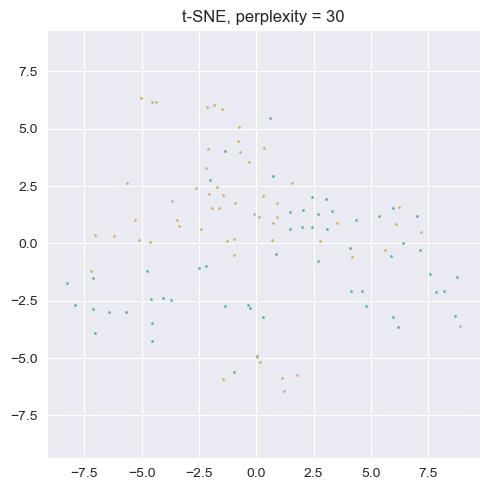

In [129]:
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal', adjustable='datalim')
colors = ['#5ab4ac', '#d8b365','#a6611a']

for target, color in zip(dis_keep, colors):
    indicesToKeep = Y_train['Diagnosis'] == target
    plt.scatter(tsne_ours[indicesToKeep,0], tsne_ours[indicesToKeep,1], s=1, c= color)
    plt.title('t-SNE, perplexity = 30')
    plt.tight_layout()


Further exploration
==========
You have now seen how to perform non-linear dimensionality reduction with different tecnhiques. Ideas for further exploration:
- Do you think you can further improve the results?
- Apply other techniques you have learned and compare
- Use another dataset (eg [winconsin breast cancer dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data), [pima diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database)) and compare the results
